# Выбор локации для скважины

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

<div> <b>Цель исследования:</b><br>
    1. Построить модель прогнозирования объема нефти<br>
    2. Оценить рентабельность разработки 200 скважин для каждого региона по результатам прогноза модели<br>
    <br>
    <b>Ход исследования:</b><br>
    1. Выгрузить таблицы<br>
    2. Изучить и подготовить признаки<br>
    3. Построить модели линейной регрессии для 3 регионов <br>
    4. Сравнить результаты моделей с действительными значениями<br>
    5. Для каждого региона применить Bootstrap с 1000 выборок по 500 значений, и посчитать прибыль для 200 лучших. <br>
    6. Построить 95% доверительный интервал <br>
</div>

## Загрузка и подготовка данных

In [1]:
!pip install pandas-profiling

  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27096 sha256=9e30fee0dcb1a76262b8ddd6107db479b037d70d8b1eccace08b193b50a8ebf5
  Stored in directory: c:\users\михаил\appdata\local\pip\cache\wheels\1d\05\04\c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin


In [65]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты на месте
</div>


In [3]:
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

In [4]:
display(data_0.describe(include='all'))

,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,fiKDv,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


In [5]:
data_0[data_0['id'].isin(data_0['id'][data_0['id'].duplicated()])].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Id некоторых скважин повторяются. Возможно это просто опечатки. Значения в значащих столбцах не повторяются, колонку ID удалим.

In [6]:
display(data_0.corr())
display(data_1.corr())
display(data_2.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Существует серьезная корреляция для второго региона параметра f2 и product. Также сеществует подобная зависимость для двух других регионов, но слабая. Также заметна небольшая зависимость между f0 и f1 для первого региона.
    
Значения f0 и f1 мало влияют на product

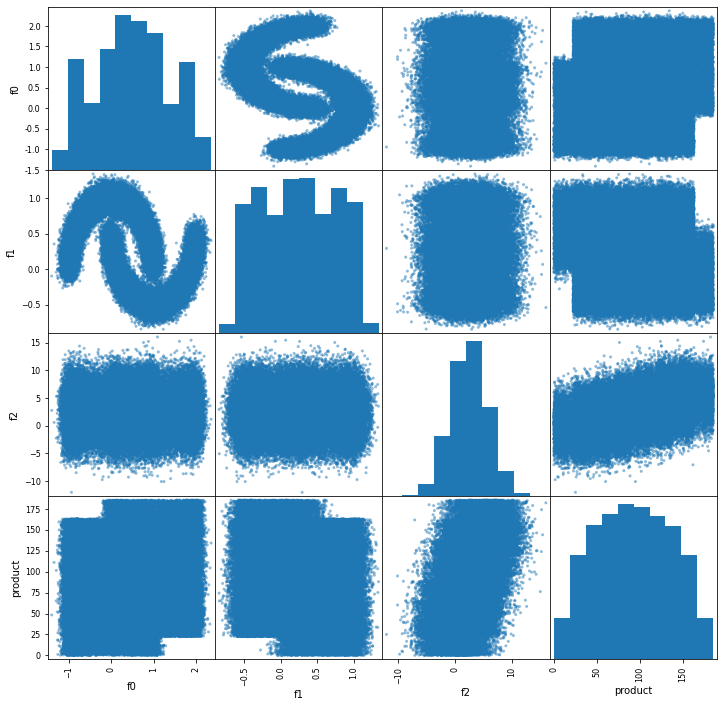

In [7]:
pd.plotting.scatter_matrix(data_0, figsize=(12,12));

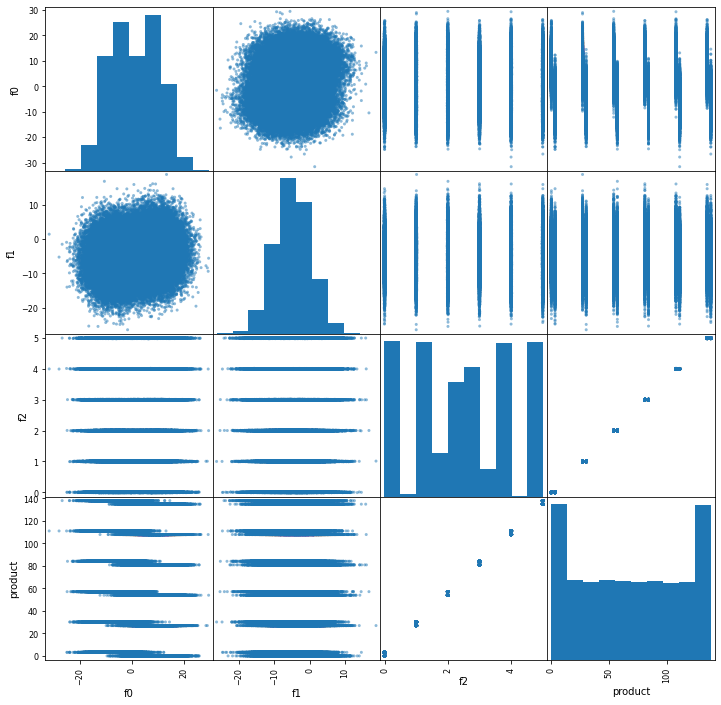

In [8]:
pd.plotting.scatter_matrix(data_1, figsize=(12,12));

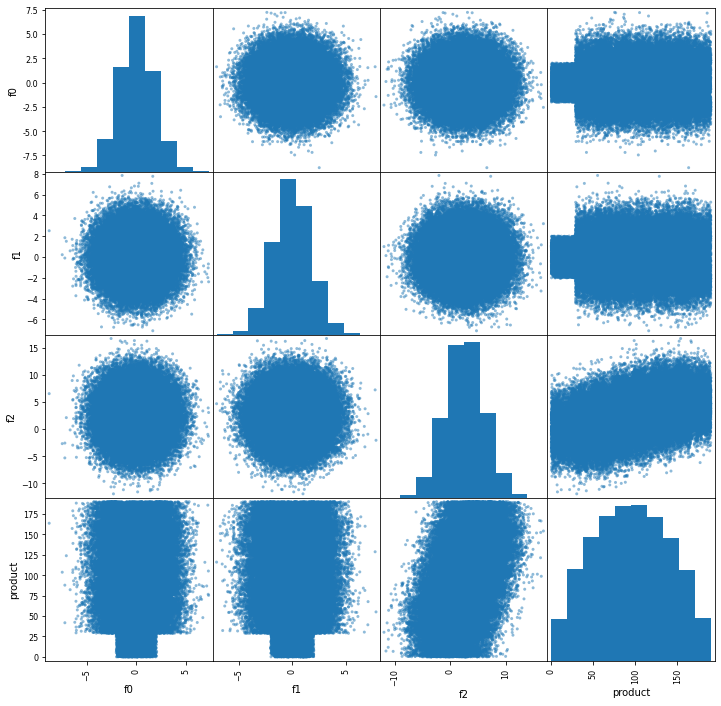

In [9]:
pd.plotting.scatter_matrix(data_2, figsize=(12,12));

In [10]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

In [11]:
pandas_profiling.ProfileReport(data_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Обучение и проверка модели

Построим модель линейной регрессии.

In [12]:
scaler = StandardScaler()
das = scaler.fit_transform(data_0.drop('product', axis=1))
das

array([[ 0.23551175, -1.48279306, -0.3945153 ],
       [ 0.95694598, -1.17024583,  0.57336845],
       [ 0.59910113, -0.19458112, -0.33332622],
       ...,
       [ 0.60696093, -0.45864844, -1.18555441],
       [ 0.57091968, -1.54377113, -0.28285494],
       [ 1.45021164, -1.02404622,  0.991371  ]])

In [81]:
def split_data(data, target='product', size=0.25):
    X = data.drop(target, axis=1)
    y = data[target]
    scaler = StandardScaler()
    X_train_f, X_valid_f, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=size, 
                                                    random_state=777
                                                  )
    X_train = scaler.fit_transform(X_train_f)
    X_valid = scaler.transform(X_valid_f)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)
    rmse = mean_squared_error(y_valid,predict, squared=False)
    predict = pd.Series(predict,name='predict', index=X_valid_f.index)
    result = X_valid_f.join(y_valid)
    result = result.join(predict)
    return(rmse,result)

In [82]:
rmse_0, result_0 = split_data(data_0)
rmse_1, result_1 = split_data(data_1)
rmse_2, result_2 = split_data(data_2)

In [83]:
print('Участок 0:',result_0['predict'].mean(),result_0['product'].mean(), rmse_0)
print('Участок 1:',result_1['predict'].mean(),result_1['product'].mean(), rmse_1)
print('Участок 2:',result_2['predict'].mean(),result_2['product'].mean(), rmse_2)

Участок 0: 92.71675294828394 92.90226093141547 37.99219303094202
Участок 1: 69.75032521418684 69.7514236660063 0.8911506041453015
Участок 2: 94.97788403611784 94.86132050091047 40.23018694848326


Средние значения предсказаний для всех регионов близки к истиным значениям, однако точность предсказаний оставляет желать лучшего. Кроме второго региона, где есть прямая зависимость между f2 и product.

## Подготовка к расчёту прибыли

In [85]:
BUDGET = 10_000_000_000
INCOME = 450_000
min_avg_oil_well = BUDGET / INCOME / 200
print(min_avg_oil_well)

111.11111111111111


Необходимый объем сырья значительно превышает средние объемы по регионам. Необходимо отбирать лучшие скважины.

## Расчёт прибыли и рисков 

Сравним результаты предсказаний модели по регионам.

In [86]:
def calc_best(data, count_best=200):

    data = data.sort_values(by='predict', ascending=False).reset_index(drop=True)
    return(data['product'].loc[:count_best].sum() * INCOME / 1_000_000_000 - 10)

In [87]:
print(calc_best(result_0))
print(calc_best(result_1))
print(calc_best(result_2))

3.505671111776808
2.477162130164917
2.329786097646643


В лучшем случае в каждом из регионов прибыль превзойдет затраты. 

Построим 95% доверительный интервал для каждого региона, а также посчитаем вероятность убытка и среднюю прибыль. 

In [88]:
def calc_mean(result):
    state = np.random.RandomState(12345)

    values = []
    for i in range(10000):
        subsample_0 = result.sample(500, replace=True, random_state=state)
        values.append(calc_best(subsample_0))
    k = pd.Series(values)
    k.hist()
    return(k.quantile(0.025),k.quantile(0.975) , k[k<0].count()/k.count(), k.mean())

(-0.015236336621487908, 1.0155840243320842, 0.0288, 0.5023802472874795)

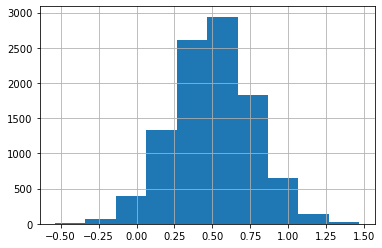

In [89]:
calc_mean(result_0)

(0.1509505701990257, 0.9514173279567238, 0.0032, 0.5565422843242044)

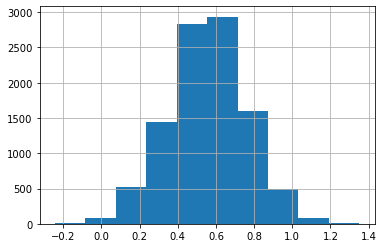

In [90]:
calc_mean(result_1)

(-0.13142165294592215, 0.9245550510041899, 0.0737, 0.3972559429825813)

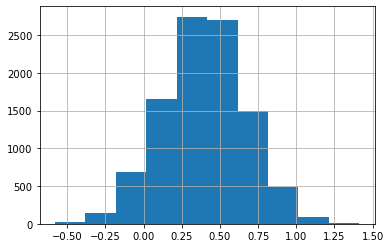

In [91]:
calc_mean(result_2)

В третьем регионе вероятность убытков выше 6%, отбрасываем его. В первом регионе вероятность убытков на грани 2.5% при 1000 подвыборок и превышает 2.5% при 10_000 подвыборок бутсрапа. Второй район дайт самые надежные оценки, всего 0,3% вероятность убытка, а средний доход максимален. 

In [83]:
pivot_result = pd.DataFrame({
    'place':['predict 0:', 'predict 1:', 'predict 2:'],
    '2.5%':[-0.02,0.15,-0.13],
    'mean':[0.50,0.56,0.40],
    '97.5%':[1.02,0.95,0.92]
})
display(pivot_result)

,place,2.5%,mean,97.5%
0,predict 0:,-0.02,0.50,1.02
1,predict 1:,0.15,0.56,0.95
2,predict 2:,-0.13,0.40,0.92


# Вывод

Дана информация о нефтяных скважинах для трех регионов. Построена модель линейной регрессии. Построены доверительные интервалы методом бутстрэп. Для первого и третьего региона вероятность убытков оказалась выше требуемой. Также средний доход для второго региона получился максимален.